## Введение.

**Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).**

**Необходимо выявить определяющие успешность с точки зрения продаж игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Имеющиеся данные - до 2016 года. Необходимо спланировать кампанию на 2017-й.**

**Описание данных**

- Name — название игры

- Platform — платформа

- Year_of_Release — год выпуска

- Genre — жанр игры

- NA_sales — продажи в Северной Америке (миллионы проданных копий)

- EU_sales — продажи в Европе (миллионы проданных копий)

- JP_sales — продажи в Японии (миллионы проданных копий)

- Other_sales — продажи в других странах (миллионы проданных копий)

- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Подготовка данных.

### Знакомство с датасетом.

**Импортируем необходимые для дальнейшей работы библиотеки.**

In [172]:
import pandas as pd
from scipy import stats as st
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Откроем файл с данными и изучим общую информацию, представленную в датасете.**

In [173]:
from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/My Drive/projects/game_market_analysis/games.csv'

df = pd.read_csv(csv_path)
display(df.head())
display(df.info())
display(df.duplicated().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

0

**Исходя из данных выше выявлены на первый взгляд следующие особенности в датафрейме:**
- Названия столбцов не в строчном регистре
- Есть пропуски в данных
- Столбец `User_Score` и `Year_of_Release` имеют неверный тип данных
- Полных строк-дубликатов нет

**Рассмотрим уникальные значения столбца `User_Score`.**

In [174]:
df['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Видим значение `'tbd'`, которое означает to be determined, т.е. рейтинг еще неопределен, находится в процессе вычисления или набора минимально необходимого количества отзывов пользователей для формирования. Заменим данные значения на -1, чтобы потом их отличать в датафрейме от актуальных числовых значений рейтинга.**

In [175]:
df['User_Score']  = df['User_Score'].replace('tbd', '-1')
df['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '-1', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Рассмотрим уникальные значения столбца `Year_of_Release`.**

In [176]:
df['Year_of_Release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

**Исправим названия столбцов на строчный регистр и неверные типы данных: для `User_Score` нужен числовой тип данных float, т.к.
это рейтинг, выражаемый дробным числом. Для `Year_of_Release` тип данных необходим integer, т.к. этот столбец указывает целочисленное значение года, но пока там есть пропуски мы не можем этого сделать, разберемся с пропусками ниже и далее уже исправим тип данных для данного столбца.**

In [177]:
df = df.rename(
    columns={'Name': 'name',
             'Platform': 'platform',
             'Platform': 'platform',
             'Year_of_Release': 'year_of_release',
             'Genre': 'genre',
             'NA_sales': 'na_sales',
             'EU_sales': 'eu_sales',
             'JP_sales': 'jp_sales',
             'Other_sales': 'other_sales',
             'Critic_Score': 'critic_score',
             'User_Score': 'user_score',
             'Rating': 'rating',
            })

df['user_score'] = df['user_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


### Изучение и заполнение пропусков данных.

**Рассмотрим теперь пропуски в столбцах и подсчитаем их долю в каждом столбце от общего числа строк.**

In [178]:
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

**Добавим в датафрейм столбец с общими продажами по всем регионам, т.к. пропусков в данных столбцах нет.**

In [179]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


**Посмотрим, какие строки имеют пропуски в столбце `'name'`.**

In [180]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


**Размер продаж относительно не высокий для данных строк, год выпуска игр тоже достаточно старый. Удалим данные строки, сохранив датафрейм без них.**

In [181]:
df = df[df['name'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  float64
 10  rating           9949 non-null   object 
 11  total_sales      16713 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.7+ MB


**Посмотрим строки с пропусками в столбце `'year_of_release'` и отсортируем их по общим продажам.**

In [182]:
df[df['year_of_release'].isna()].sort_values(by='total_sales', ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,3.50
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,3.06
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.53
...,...,...,...,...,...,...,...,...,...,...,...,...
16017,Dream Dancer,DS,NaN,Misc,0.01,0.00,0.00,0.00,NaN,-1.0,E,0.01
15966,Dinotopia: The Sunstone Odyssey,GC,NaN,Action,0.01,0.00,0.00,0.00,50.0,-1.0,T,0.01
15953,PDC World Championship Darts 2008,DS,NaN,Sports,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01
15816,Without Warning,XB,NaN,Shooter,0.01,0.00,0.00,0.00,45.0,2.0,M,0.01


**Видим, что пропуски в году релиза есть как у игр с большими продажами, так и с малыми.**

**Сгруппируем датафрейм с пропусками в столбце `'year_of_release'` по типам платформ и посчитаем их долю.**

In [183]:
df[df['year_of_release'].isna()].groupby('platform')['name'].count()/len(df[df['year_of_release'].isna()])

platform
2600    0.063197
3DS     0.029740
DS      0.111524
GB      0.003717
GBA     0.040892
GC      0.052045
N64     0.011152
PC      0.063197
PS      0.026022
PS2     0.126394
PS3     0.092937
PSP     0.059480
PSV     0.003717
Wii     0.126394
X360    0.111524
XB      0.078067
Name: name, dtype: float64

**Видим, что нет какой-то четкой связи между количеством пропусков в столбце `'year_of_release'` и типом платформы.**

**Сгруппируем датафрейм с пропусками в столбце `'year_of_release'` по жанрам и посчитаем их долю.**

In [184]:
df[df['year_of_release'].isna()].groupby('genre')['name'].count()/len(df[df['year_of_release'].isna()])

genre
Action          0.230483
Adventure       0.037175
Fighting        0.044610
Misc            0.107807
Platform        0.037175
Puzzle          0.040892
Racing          0.085502
Role-Playing    0.063197
Shooter         0.100372
Simulation      0.059480
Sports          0.156134
Strategy        0.037175
Name: name, dtype: float64

**Видим, что нет какой-то четкой связи между количеством пропусков в столбце `'year_of_release'` и типом платформы.**

**Сгруппируем датафрейм с пропусками в столбце `'year_of_release'` по рейтигу ESRB и посчитаем их долю.**

In [185]:
df[df['year_of_release'].isna()].groupby('rating')['name'].count()/len(df[df['year_of_release'].isna()])

rating
E       0.256506
E10+    0.100372
M       0.100372
RP      0.007435
T       0.208178
Name: name, dtype: float64

**Видно, что нет какой-то четкой связи между количеством пропусков в столбце `'year_of_release'` и рейтингом ESRB игры.**

**Для продвижения дальше в аналитике  данных заменим пропуски в столбце `'year_of_release'` на значения -1. После изучения популярности платформ и связи их с продажами, возможно, дополнительно проанализируем эти пропуски и заменим их на актуальные значения, используя тот же поисковик. Удалять эти сроки не будем, т.к. там потенциально могут содержаться игры, которые потенциально принесут большую прибыль в продажах за 2017 год.**

In [186]:
df['year_of_release'] = df['year_of_release'].fillna(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  float64
 10  rating           9949 non-null   object 
 11  total_sales      16713 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.7+ MB


**Теперь как и планировалось ранее, изменим тип данных столбца `'year_of_release'` на целочисленный. И проверим долю пропусков в столбцах датафрейме после всех преобразований.**

In [187]:
df['year_of_release'] = df['year_of_release'].astype(int)
display(df.info())
df.isna().mean()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  float64
 10  rating           9949 non-null   object 
 11  total_sales      16713 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.7+ MB


None

name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513133
user_score         0.400826
rating             0.404715
total_sales        0.000000
dtype: float64

**Видим, что наибольшую долю пропусков содержат столбцы, которые относятся к рейтингу игр.**

**Проверим, есть ли какая-то прямая очевидная связь между пропусками в рейтинговых столбцах `'critic_score'`, `'user_score'`, `'rating'` с жанром, платформой и продажами.**

**Начнем со столбца `'critic_score'`. Посмотрим долю пропусков в данном столбце в зависимости от жанра, платформы и продаж.**

In [188]:
display(df[df['critic_score'].isna()]
        .groupby('genre')['name']
        .count()
        / len(df[df['critic_score'].isna()]))

display(df[df['critic_score'].isna()]
        .groupby('platform')['name']
        .count()
        / len(df[df['critic_score'].isna()]))

df['total_sales_range'] = pd.cut(df['total_sales'], 20)

(df[df['critic_score'].isna()]
        .groupby('total_sales_range')['name']
        .count()
        / len(df[df['critic_score'].isna()]))

genre
Action          0.172458
Adventure       0.114272
Fighting        0.051306
Misc            0.143074
Platform        0.045592
Puzzle          0.041511
Racing          0.059118
Role-Playing    0.088736
Shooter         0.044193
Simulation      0.060751
Sports          0.134562
Strategy        0.044426
Name: name, dtype: float64

platform
2600    0.015508
3DO     0.000350
3DS     0.041045
DC      0.004431
DS      0.167211
GB      0.011427
GBA     0.044776
GC      0.012593
GEN     0.003148
GG      0.000117
N64     0.037197
NES     0.011427
NG      0.001399
PC      0.030201
PCFX    0.000117
PS      0.116255
PS2     0.100630
PS3     0.059585
PS4     0.016325
PSP     0.087104
PSV     0.036147
SAT     0.020173
SCD     0.000700
SNES    0.027868
TG16    0.000233
WS      0.000700
Wii     0.085704
WiiU    0.006646
X360    0.040345
XB      0.011544
XOne    0.009095
Name: name, dtype: float64

total_sales_range
(-0.0825, 4.127]    0.989855
(4.127, 8.254]      0.007113
(8.254, 12.381]     0.001283
(12.381, 16.508]    0.000583
(16.508, 20.635]    0.000466
(20.635, 24.762]    0.000233
(24.762, 28.889]    0.000117
(28.889, 33.016]    0.000233
(33.016, 37.143]    0.000000
(37.143, 41.27]     0.000117
(41.27, 45.397]     0.000000
(45.397, 49.524]    0.000000
(49.524, 53.651]    0.000000
(53.651, 57.778]    0.000000
(57.778, 61.905]    0.000000
(61.905, 66.032]    0.000000
(66.032, 70.159]    0.000000
(70.159, 74.286]    0.000000
(74.286, 78.413]    0.000000
(78.413, 82.54]     0.000000
Name: name, dtype: float64

**Только в столбце, связанном с продажами, можно увидеть отчетливую связь наличия пропусков в столбце `'critic_score'`. Почти 99% пропусков столбца `'critic_score'` приходится на самый нижний диапазон продаж, что можно объяснить так: игры, которые не были очень популярны имели относительно низкие продажи и, соответственно, маловероятны были "замечены" критиками.**

**Заполним данные пропуски значением -1.**

In [189]:
df['critic_score'] = df['critic_score'].fillna(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               16713 non-null  object  
 1   platform           16713 non-null  object  
 2   year_of_release    16713 non-null  int64   
 3   genre              16713 non-null  object  
 4   na_sales           16713 non-null  float64 
 5   eu_sales           16713 non-null  float64 
 6   jp_sales           16713 non-null  float64 
 7   other_sales        16713 non-null  float64 
 8   critic_score       16713 non-null  float64 
 9   user_score         10014 non-null  float64 
 10  rating             9949 non-null   object  
 11  total_sales        16713 non-null  float64 
 12  total_sales_range  16713 non-null  category
dtypes: category(1), float64(7), int64(1), object(4)
memory usage: 1.7+ MB


**Продолжим для столбца `'user_score'`. Посмотрим долю пропусков в данном столбце в зависимости от жанра, платформы и продаж.**

In [190]:
display(df[df['user_score'].isna()]
        .groupby('genre')['name']
        .count()
        / len(df[df['user_score'].isna()]))

display(df[df['user_score'].isna()]
        .groupby('platform')['name']
        .count()
        / len(df[df['user_score'].isna()]))

(df[df['user_score'].isna()]
        .groupby('total_sales_range')['name']
        .count()
        / len(df[df['user_score'].isna()]))

genre
Action          0.173608
Adventure       0.125989
Fighting        0.061352
Misc            0.128676
Platform        0.047918
Puzzle          0.035976
Racing          0.055979
Role-Playing    0.108225
Shooter         0.044783
Simulation      0.043589
Sports          0.124198
Strategy        0.049709
Name: name, dtype: float64

platform
2600    0.019854
3DO     0.000448
3DS     0.043290
DC      0.005672
DS      0.131214
GB      0.014629
GBA     0.045529
GC      0.012987
GEN     0.004030
GG      0.000149
N64     0.047619
NES     0.014629
NG      0.001791
PC      0.023138
PCFX    0.000149
PS      0.147783
PS2     0.101508
PS3     0.054784
PS4     0.019257
PSP     0.099269
PSV     0.041797
SAT     0.025825
SCD     0.000896
SNES    0.035677
TG16    0.000299
WS      0.000896
Wii     0.047768
WiiU    0.006270
X360    0.031647
XB      0.013136
XOne    0.008061
Name: name, dtype: float64

total_sales_range
(-0.0825, 4.127]    0.987461
(4.127, 8.254]      0.008658
(8.254, 12.381]     0.001642
(12.381, 16.508]    0.000746
(16.508, 20.635]    0.000597
(20.635, 24.762]    0.000299
(24.762, 28.889]    0.000149
(28.889, 33.016]    0.000299
(33.016, 37.143]    0.000000
(37.143, 41.27]     0.000149
(41.27, 45.397]     0.000000
(45.397, 49.524]    0.000000
(49.524, 53.651]    0.000000
(53.651, 57.778]    0.000000
(57.778, 61.905]    0.000000
(61.905, 66.032]    0.000000
(66.032, 70.159]    0.000000
(70.159, 74.286]    0.000000
(74.286, 78.413]    0.000000
(78.413, 82.54]     0.000000
Name: name, dtype: float64

**Аналогично, только в столбце, связанном с продажами, можно увидеть отчетливую связь наличия пропусков в столбце `'user_score'`. Почти 99% пропусков столбца `'user_score'` приходится на самый нижний диапазон продаж, что можно объяснить так: игры, которые не были очень популярны имели относительно низкие продажи и, соответственно, были "обделены" вниманием и оценками пользователей.**

**Заполним данные пропуски значением -1.**

In [191]:
df['user_score'] = df['user_score'].fillna(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               16713 non-null  object  
 1   platform           16713 non-null  object  
 2   year_of_release    16713 non-null  int64   
 3   genre              16713 non-null  object  
 4   na_sales           16713 non-null  float64 
 5   eu_sales           16713 non-null  float64 
 6   jp_sales           16713 non-null  float64 
 7   other_sales        16713 non-null  float64 
 8   critic_score       16713 non-null  float64 
 9   user_score         16713 non-null  float64 
 10  rating             9949 non-null   object  
 11  total_sales        16713 non-null  float64 
 12  total_sales_range  16713 non-null  category
dtypes: category(1), float64(7), int64(1), object(4)
memory usage: 1.7+ MB


**Продолжим для столбца `'rating'`. Посмотрим долю пропусков в данном столбце в зависимости от жанра, платформы и продаж.**

In [192]:
display(df[df['rating'].isna()]
        .groupby('genre')['name']
        .count()
        / len(df[df['rating'].isna()]))

display(df[df['rating'].isna()]
        .groupby('platform')['name']
        .count()
        / len(df[df['rating'].isna()]))

(df[df['rating'].isna()]
        .groupby('total_sales_range')['name']
        .count()
        / len(df[df['rating'].isna()]))

genre
Action          0.174601
Adventure       0.126700
Fighting        0.060763
Misc            0.128326
Platform        0.047161
Puzzle          0.035186
Racing          0.055736
Role-Playing    0.106594
Shooter         0.044944
Simulation      0.045092
Sports          0.124039
Strategy        0.050857
Name: name, dtype: float64

platform
2600    0.019663
3DO     0.000444
3DS     0.043170
DC      0.005618
DS      0.129805
GB      0.014488
GBA     0.044352
GC      0.012862
GEN     0.003992
GG      0.000148
N64     0.047161
NES     0.014488
NG      0.001774
PC      0.029568
PCFX    0.000148
PS      0.146215
PS2     0.100532
PS3     0.056032
PS4     0.020254
PSP     0.098315
PSV     0.041248
SAT     0.025577
SCD     0.000887
SNES    0.035334
TG16    0.000296
WS      0.000887
Wii     0.047014
WiiU    0.006209
X360    0.031047
XB      0.013454
XOne    0.009018
Name: name, dtype: float64

total_sales_range
(-0.0825, 4.127]    0.987729
(4.127, 8.254]      0.008427
(8.254, 12.381]     0.001626
(12.381, 16.508]    0.000739
(16.508, 20.635]    0.000591
(20.635, 24.762]    0.000296
(24.762, 28.889]    0.000148
(28.889, 33.016]    0.000296
(33.016, 37.143]    0.000000
(37.143, 41.27]     0.000148
(41.27, 45.397]     0.000000
(45.397, 49.524]    0.000000
(49.524, 53.651]    0.000000
(53.651, 57.778]    0.000000
(57.778, 61.905]    0.000000
(61.905, 66.032]    0.000000
(66.032, 70.159]    0.000000
(70.159, 74.286]    0.000000
(74.286, 78.413]    0.000000
(78.413, 82.54]     0.000000
Name: name, dtype: float64

**Аналогично, только в столбце, связанном с продажами, можно увидеть отчетливую связь наличия пропусков в столбце `'rating'`. Почти 99% пропусков столбца `'rating'` приходится на самый нижний диапазон продаж, что можно объяснить так: игры, которые не были очень популярны имели относительно низкие продажи и, соответственно, были "обделены" вниманием организацией Entertainment Software Rating Board, основанной в 1994 году, и соответственно ее оценкой.**

**Заполним данные пропуски значением -1.**

In [193]:
df['rating'] = df['rating'].fillna(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               16713 non-null  object  
 1   platform           16713 non-null  object  
 2   year_of_release    16713 non-null  int64   
 3   genre              16713 non-null  object  
 4   na_sales           16713 non-null  float64 
 5   eu_sales           16713 non-null  float64 
 6   jp_sales           16713 non-null  float64 
 7   other_sales        16713 non-null  float64 
 8   critic_score       16713 non-null  float64 
 9   user_score         16713 non-null  float64 
 10  rating             16713 non-null  object  
 11  total_sales        16713 non-null  float64 
 12  total_sales_range  16713 non-null  category
dtypes: category(1), float64(7), int64(1), object(4)
memory usage: 1.7+ MB


### Проверка на неявные дубликаты.

**Проверим теперь столбцы на неявные дубликаты. Начнем со столбца `'rating'`.**

In [194]:
df['rating'].unique()

array(['E', -1, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

**Cтолбец `Rating` - это рейтинг ESRB (Entertainment Software Rating Board):**

- `'E'` - *Everyone* - для всех возрастов.
- `'E10+'` - *Everyone 10+* - для возраста 10+.
- `'T'` - *Teen* - для возраста 13+.
- `'M'` - *Mature* - для возраста 17+.
- `'AO'` - *Adults only* - для возраста 18+.
- `'RP'` - *Rating pending* - используется только в рекламных и маркетинговых материалах, когда заявка уже была подана на оценку ESRB, но не была еще рассмотрена и присвоен рейтинг.
- `'K-A'` - *Kids to adults* - рейтинг ранее назывался K-A (Kids to Adults), но был изменен в 1998 на рейтинг E - т.е. для всех.
- `'EC'` - *Early Childhood* - контент подходит для возраста 3+.

**Делаем вывод, что рейтинг `'K-A'` необходимо заменить на актуальный `'E'`, a пропуски в виде -1 и `'RP'` на 'Empty', т.к. смысловая нагрузка одинаковая.**

In [195]:
df['rating']  = df['rating'].replace('K-A', 'E')
df['rating']  = df['rating'].replace('RP', 'Empty')
df['rating']  = df['rating'].replace(-1, 'Empty')
df['rating'].unique()

array(['E', 'Empty', 'M', 'T', 'E10+', 'AO', 'EC'], dtype=object)

**Проверим теперь на неявный дубликаты столбец `'genre'`.**

In [196]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

**Используя поисковик удалось выяснить, что неявных дубликатов здесь нет.**

**Поищем дубликаты в столбцах `'name'` и `'platform'`.**

In [197]:
df[df.duplicated(subset=['name'], keep=False)].sort_values(by='name').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total_sales_range
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,-1.0,-1.0,Empty,0.51,"(-0.0825, 4.127]"
3358,Frozen: Olaf's Quest,3DS,2013,Platform,0.27,0.27,0.00,0.05,-1.0,-1.0,Empty,0.59,"(-0.0825, 4.127]"
14658,007: Quantum of Solace,PC,2008,Action,0.01,0.01,0.00,0.00,70.0,6.3,T,0.02,"(-0.0825, 4.127]"
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65.0,-1.0,T,0.13,"(-0.0825, 4.127]"
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54.0,7.5,T,0.65,"(-0.0825, 4.127]"


**Видим, что название игры хоть и дублируется, но при этом название платформы может отличаться, и для каждой пары игра-платформа есть своя статистика продаж. Поэтому поиск дубликатов для этих двух столбцов нужно производить в связанной паре. Сделаем это.**

In [198]:
df[df.duplicated(subset=['name', 'platform'], keep=False)].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total_sales_range
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56,"(-0.0825, 4.127]"
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01,"(-0.0825, 4.127]"
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T,1.56,"(-0.0825, 4.127]"
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T,1.25,"(-0.0825, 4.127]"
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T,0.29,"(-0.0825, 4.127]"
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T,0.08,"(-0.0825, 4.127]"
1745,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+,1.17,"(-0.0825, 4.127]"
4127,Sonic the Hedgehog,PS3,-1,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,0.48,"(-0.0825, 4.127]"


**Используя поисковик, удалось определить, что NFS Most Wanted действительно имело две версии: выпущенную в 2005 и выпущенную в 2012 годах. Что касается первой строки и последней - данные игры действительно задублированы, необходимо удалить данные дубликаты. Сделаем это.**

In [199]:
df = df.drop([16230, 4127])

**Рассмотрим столбец `'total_sales'`.**

In [200]:
df['total_sales'].describe()

count    16711.000000
mean         0.533349
std          1.548370
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

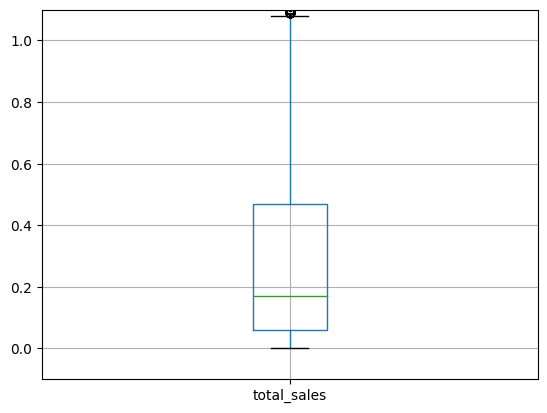

In [201]:
plt.ylim([-0.1,1.1])
df.boxplot(column='total_sales');

**Видим, что бОльшая часть значений датафрейма лежит в диапазоне от 0 до ~1.1 млн. суммарно реализованных экземпляров определенных игр.**

### Выводы раздела.

**После исследования данных в столбцах sales с использованием информации из интернета было определено, что данные числа обозначают количество проданных экземпляров игры в млн. ед. на момент выгрузки этих данных, т.е. за всё время, а не только в первый год\года выпуска игры.**

**Видим, что бОльшая часть значений датафрейма лежит в диапазоне от 0 до ~1.1 млн. суммарно реализованных экземпляров игр.**

**Пропуски в столбцах, отвечающих за рейтинг (`'critic_score'`, `'user_score'`, `'rating'`), связаны с играми, реализованными в меньшем количестве экземпляров, т.е. менее популярных.**

**Пропуски в столбце `'year_of_release'` и `'name'` связаны, скорее всего, с проблемой при выгрузке данных.**

**Полных строчек-дубликатов в датафрейме не обнаружено, помимо двух строк с указанием одинаковой игры для одинаковой платформы.**

**Найдены неявные дубликаты среди значений рейтинга ESRB в столбце `'rating'`.**

## Исследовательский анализ данных.

### Распределение количества выпускаемых игр по годам.

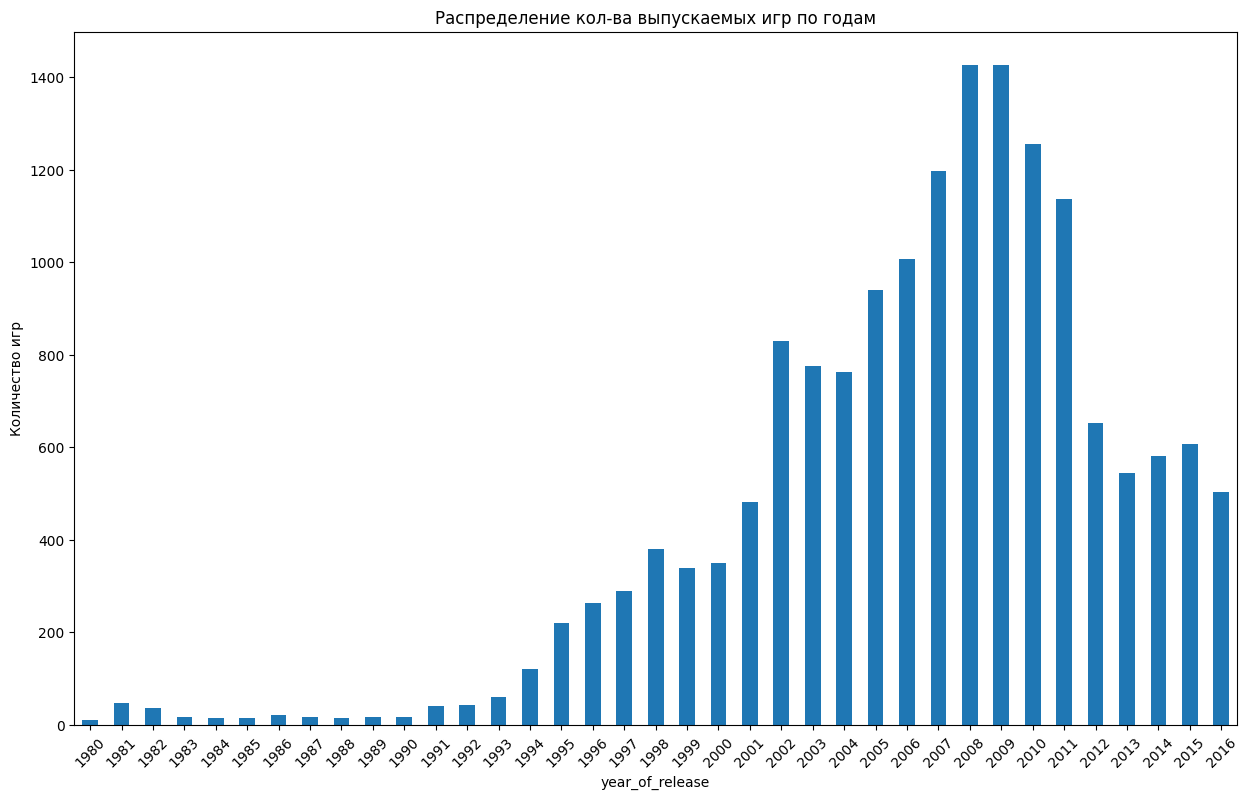

In [202]:
plt.title('Раcпределение кол-ва выпускаемых игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
(df[df['year_of_release'] > 0].groupby('year_of_release')['name'].count() # >0 - это фильтр пропусков в данных по году
 .plot(kind='bar', figsize=(15, 9), rot=45));

**Видим, что начиная с 1994 идет стремительный рост количества выпускаемых игр, при этом локальный спад с плато есть на 1998-2000 и на 2002-2004 годах. Рост наблюдается до 2008 года, с 2009 года идет достаточно резкий спад до 2013 года, после чего наблюдается локальное плато в росте.**

### Распределение данных по платформам.

**Посмотрим, как распределяется количество проданных экземпляров игр по платформам за всё время до 2016 года.**

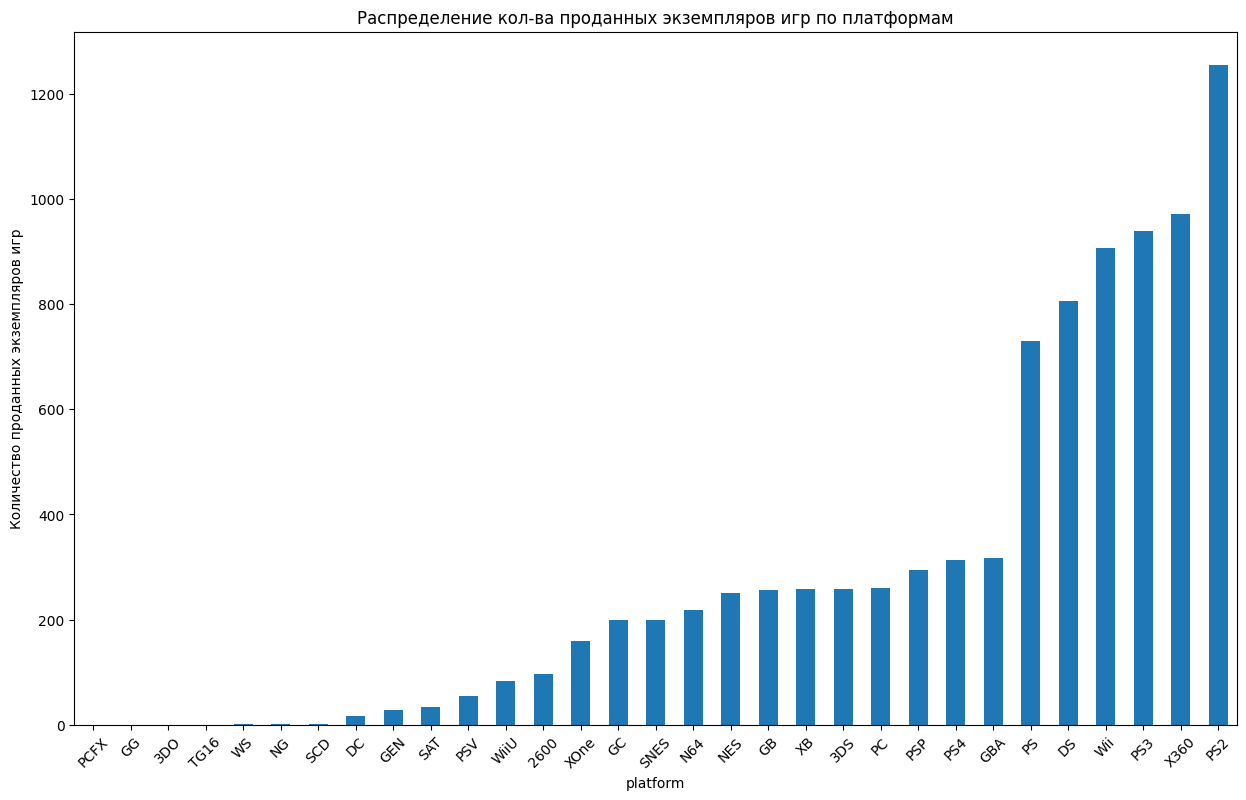

In [203]:
plt.title('Распределение кол-ва проданных экземпляров игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных экземпляров игр')
(df.groupby('platform').sum(numeric_only=True)
 .sort_values(by='total_sales')['total_sales']
 .plot(kind='bar', figsize=(15, 9), rot=45));

**Посмотрим, как при этом для платформ с самыми большими продажами распределяется кол-во выпускаемых игр по годам.**

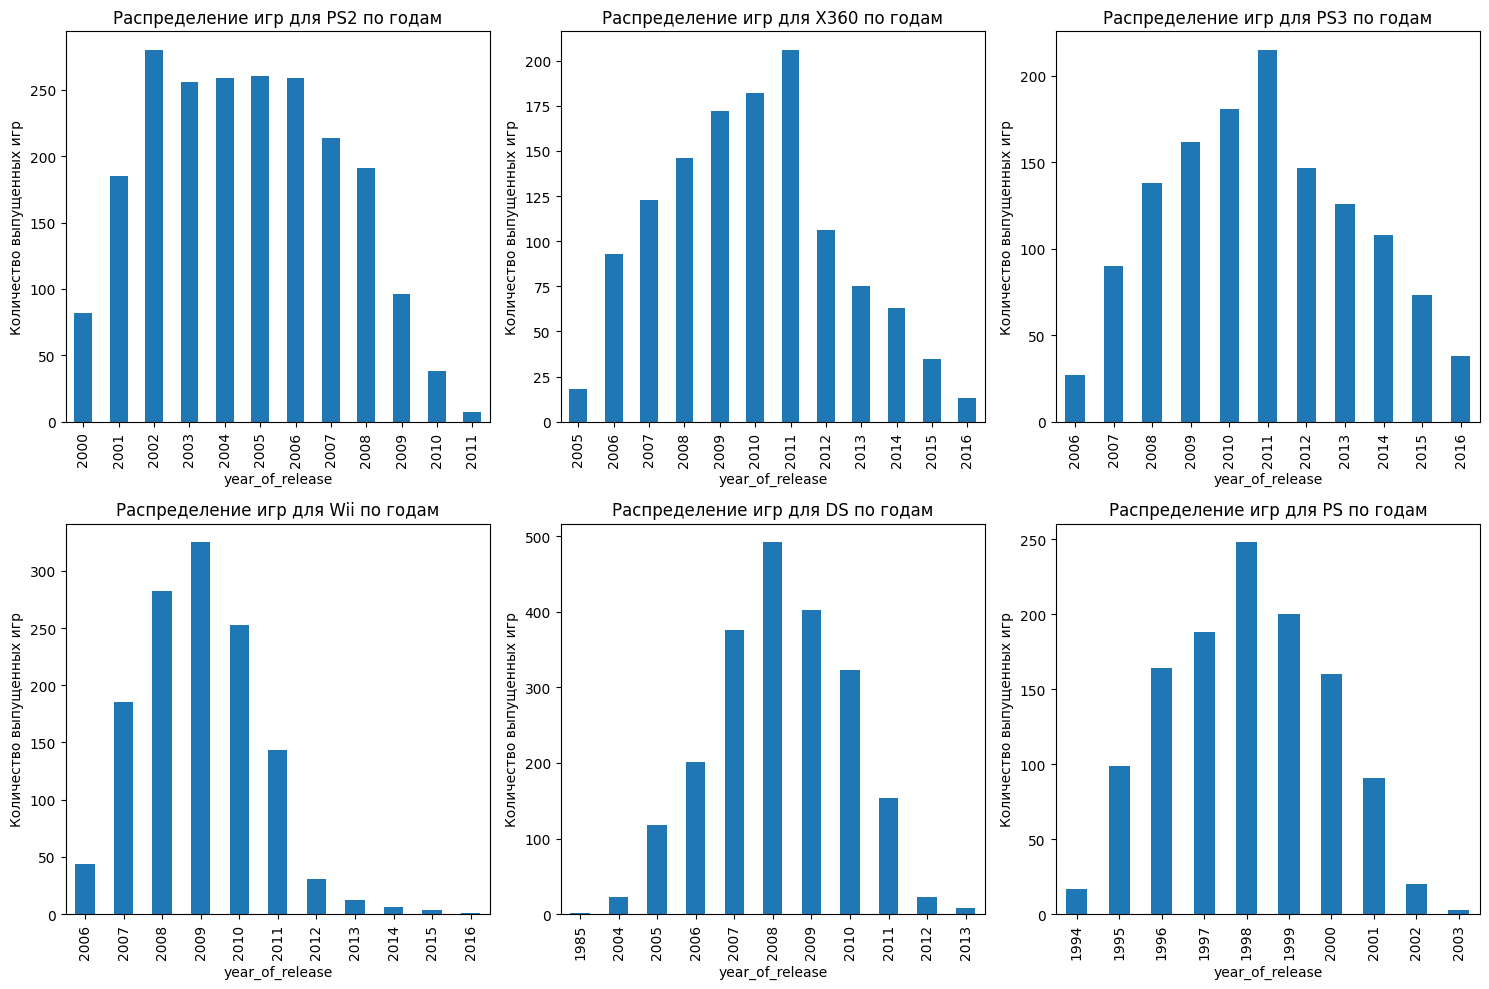

In [204]:
def plot_games_per_year_for_X(df, platform): #напишем функцию, строящую график распределения по годам для конкретной платформы
    plt.title(f'Распределение игр для {platform} по годам')
    plt.xlabel('Год')
    plt.ylabel('Количество выпущенных игр')
    (df[(df['platform'] == platform) & (df['year_of_release'] > 0)]
     .groupby('year_of_release')
     .count()['name']
     .plot(kind='bar'))

test = df.groupby('platform').sum(numeric_only=True).sort_values(by='total_sales', ascending=False)['total_sales'].reset_index()
test = test.head(6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # создаем сетку из графиков 2x3

for index, ax in enumerate(axes.flat):
    if index < len(test['platform']):
        platform = test['platform'][index]
        plt.sca(ax)
        plot_games_per_year_for_X(df, platform)

plt.tight_layout()
plt.show()

**Видим, что для большинства платформ характерен сначала рост количества выпускаемых игр, а потом - спад. Пиковое значение приходится обычно на середину жизненного цикла платформы.**

**Посмотрим, как распределяется количество выпущенных игр по платформам за всё время до 2016 года.**

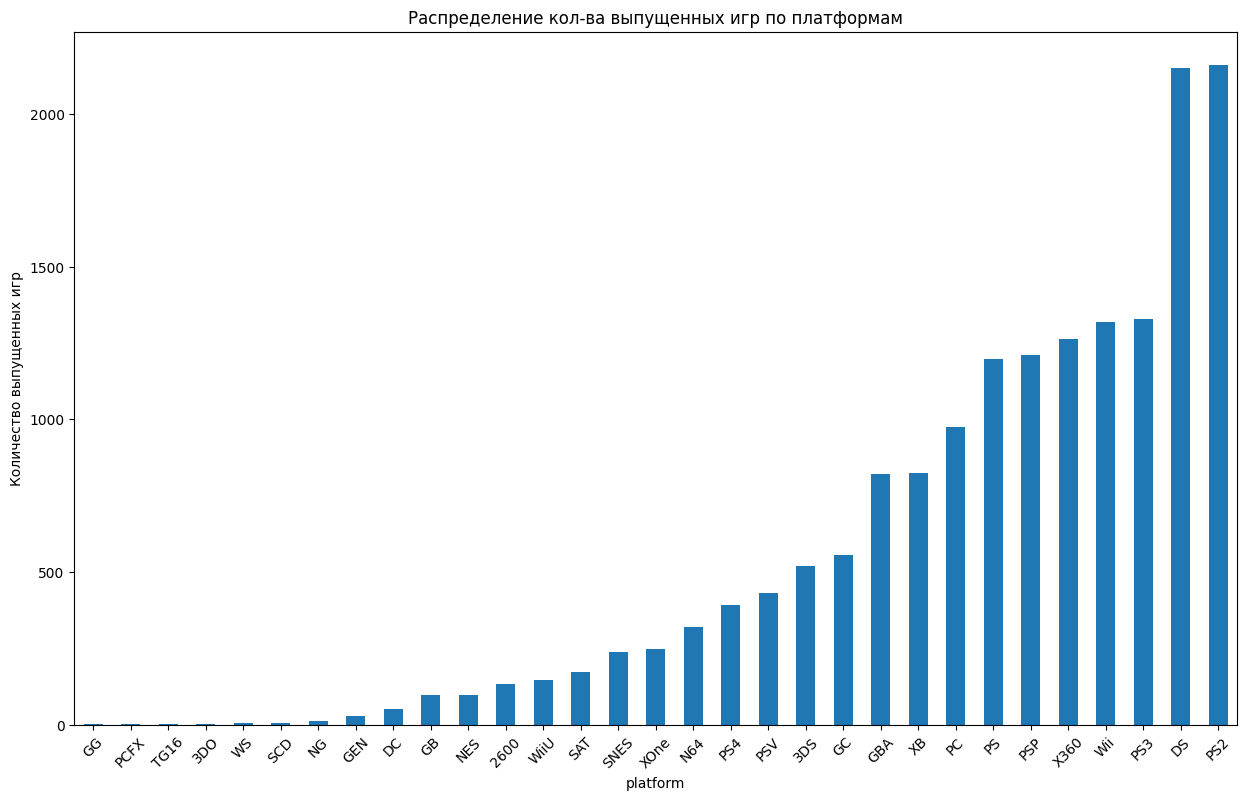

In [205]:
plt.title('Распределение кол-ва выпущенных игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество выпущенных игр')
(df.groupby('platform').count()
 .sort_values(by='name')['name']
 .plot(kind='bar', figsize=(15, 9), rot=45));

**Изучим теперь срок жизни каждой из платформ с точки зрения года начала и окончания выпуска игр для нее.**

In [217]:
# формируем датафрейм с группировкой по платформам с указаним мин и макс значений года выпуска игр
t = df[df['year_of_release'] > 0] \
 .groupby('platform') \
     .agg(['min', 'max'])['year_of_release'] \
         .reset_index()

# формируем датафрейм с группировкой по платформам с указаним суммы реализованных экземпляров игр за всё время
t1 = df[df['year_of_release'] > 0] \
 .groupby('platform') \
     .sum(numeric_only=True)['total_sales'] \
         .reset_index()
# создаем столбец для указания времени "жизни" платформы в годах, актуально для тех, кто уже не выпускал игры после 2015
t['years'] = t['max'] - t['min']

# формируем датафрейм с группировкой по платформам с указаним мин и макс значений года выпуска игр и суммы реализ. экз. игр
df_platforms = t.merge(t1, on='platform') \
 .sort_values(by='total_sales', ascending=True) \
     .reset_index(drop=True)

df_platforms

,platform,min,max,years,total_sales
0,PCFX,1996,1996,0,0.03
1,GG,1992,1992,0,0.04
2,3DO,1994,1995,1,0.10
3,TG16,1995,1995,0,0.16
4,WS,1999,2001,2,1.42
5,NG,1993,1996,3,1.44
6,SCD,1993,1994,1,1.86
7,DC,1998,2008,10,15.95
8,GEN,1990,1994,4,28.35
9,SAT,1994,1999,5,33.59


**Теперь у нас есть таблица, в которой мы можем видеть для каждой платформы срок ее "жизни" на рынке на данный момент времени (на 2016 год), а также суммарные продажи игр для данной платформы в млн. ед.**

**Отфильтруем платформы с малым количеством проданных экземпляров игр, с учетом того, чтобы туда не попали платформы, которые имеют макс. год выпуска игр 2016, т.к. таким образом мы случайно можем отфильтровать платформы, которые имеют на 2016 год небольшие продажи игр по причине новизны платформы, а не по причине их непопулярности.**


In [207]:
df_platforms_filtered = df_platforms[df_platforms['total_sales'] > 2].copy()
df_platforms_filtered

,platform,min,max,years,total_sales
7,DC,1998,2008,10,15.95
8,GEN,1990,1994,4,28.35
9,SAT,1994,1999,5,33.59
10,PSV,2011,2016,5,53.81
11,WiiU,2012,2016,4,82.19
12,2600,1980,1989,9,86.48
13,XOne,2013,2016,3,159.32
14,GC,2001,2007,6,196.73
15,SNES,1990,1999,9,200.04
16,N64,1996,2002,6,218.01


**Оценим теперь характерный срок "жизни" игровых платформ. Построим теперь диаграмму размаха для значений срока жизни платформ.**

**Построим ее для двух случаев:**
- (1) Когда отфильтрованы платформы, которые еще актуальны на 2016 год, т.е. смотрим однозначно исторические данные без учета платформ, которые могут быть актуальны и на следующий год;
- (2) Когда используются все платформы из датафрейма за исключением тех, которые мы исключили по причине не актуальности и малых продаж.

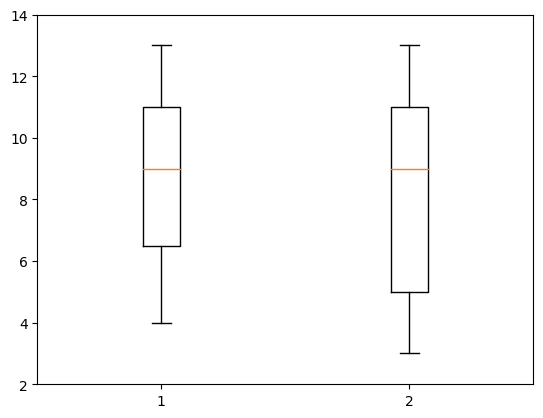

In [208]:
t_1 = df_platforms_filtered[df_platforms_filtered['max'] < 2016]['years']
t_2 = df_platforms_filtered['years']
plt.ylim(2, 14)
plt.boxplot ([t_1, t_2]);

In [209]:
display(t_1.describe())
t_2.describe()

count    15.00000
mean      9.80000
std       5.63408
min       4.00000
25%       6.50000
50%       9.00000
75%      11.00000
max      28.00000
Name: years, dtype: float64

count    24.000000
mean      9.541667
std       6.807791
min       3.000000
25%       5.000000
50%       9.000000
75%      11.000000
max      31.000000
Name: years, dtype: float64

**Видим, что медианное значение в каждом из данных случаев не меняется. Т.е. можно сделать вывод, что характерный срок жизни платформы составляет 9 лет. При этом помним из исследования выше, что у каждой платформы есть сначала рост кол-ва выпускаемых игр, затем пик, после которого идет спад, т.е. пик популярности платформы и игр для нее приходится на 5й год ее жизненного цикла. Нужно учесть данную информацию.**

**Для того, чтобы можно дальше анализировать данные с учетом нашей итоговой задачи - выбрать игры и платформы, которые будут иметь наилучший потенциал продаж в 2017 году - необходимо отфильтровать исходный датафрейм по играм, которые выпускались не раньше: 2017 - 5 = 2012 года.**

In [210]:
df_filtered = df[df['year_of_release'] >= 2012].copy()
df_filtered

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total_sales_range
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,"(20.635, 24.762]"
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,"(12.381, 16.508]"
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Empty,14.63,"(12.381, 16.508]"
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,Empty,14.60,"(12.381, 16.508]"
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79,"(12.381, 16.508]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,Empty,0.01,"(-0.0825, 4.127]"
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,Empty,0.01,"(-0.0825, 4.127]"
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,Empty,0.01,"(-0.0825, 4.127]"
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,Empty,0.01,"(-0.0825, 4.127]"


### Анализ данных за актуальный период.

**Определим, какие платформы лидируют по продажам, а также растут они или падают. Выберем несколько потенциально прибыльных платформ.**

**Построим график зависимости общих продаж от платформы.**

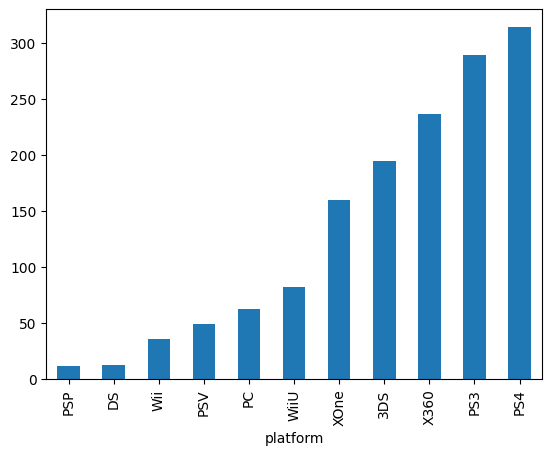

In [211]:
df_filtered.groupby('platform').sum(numeric_only=True).sort_values(by='total_sales')['total_sales'].plot(kind='bar');

**Посмотрим теперь как меняется кол-во выпускаемых игр под каждую из топ-9 по продажам платформ в зависимости от года, тем самым увидим рост или падение для каждой из них.**

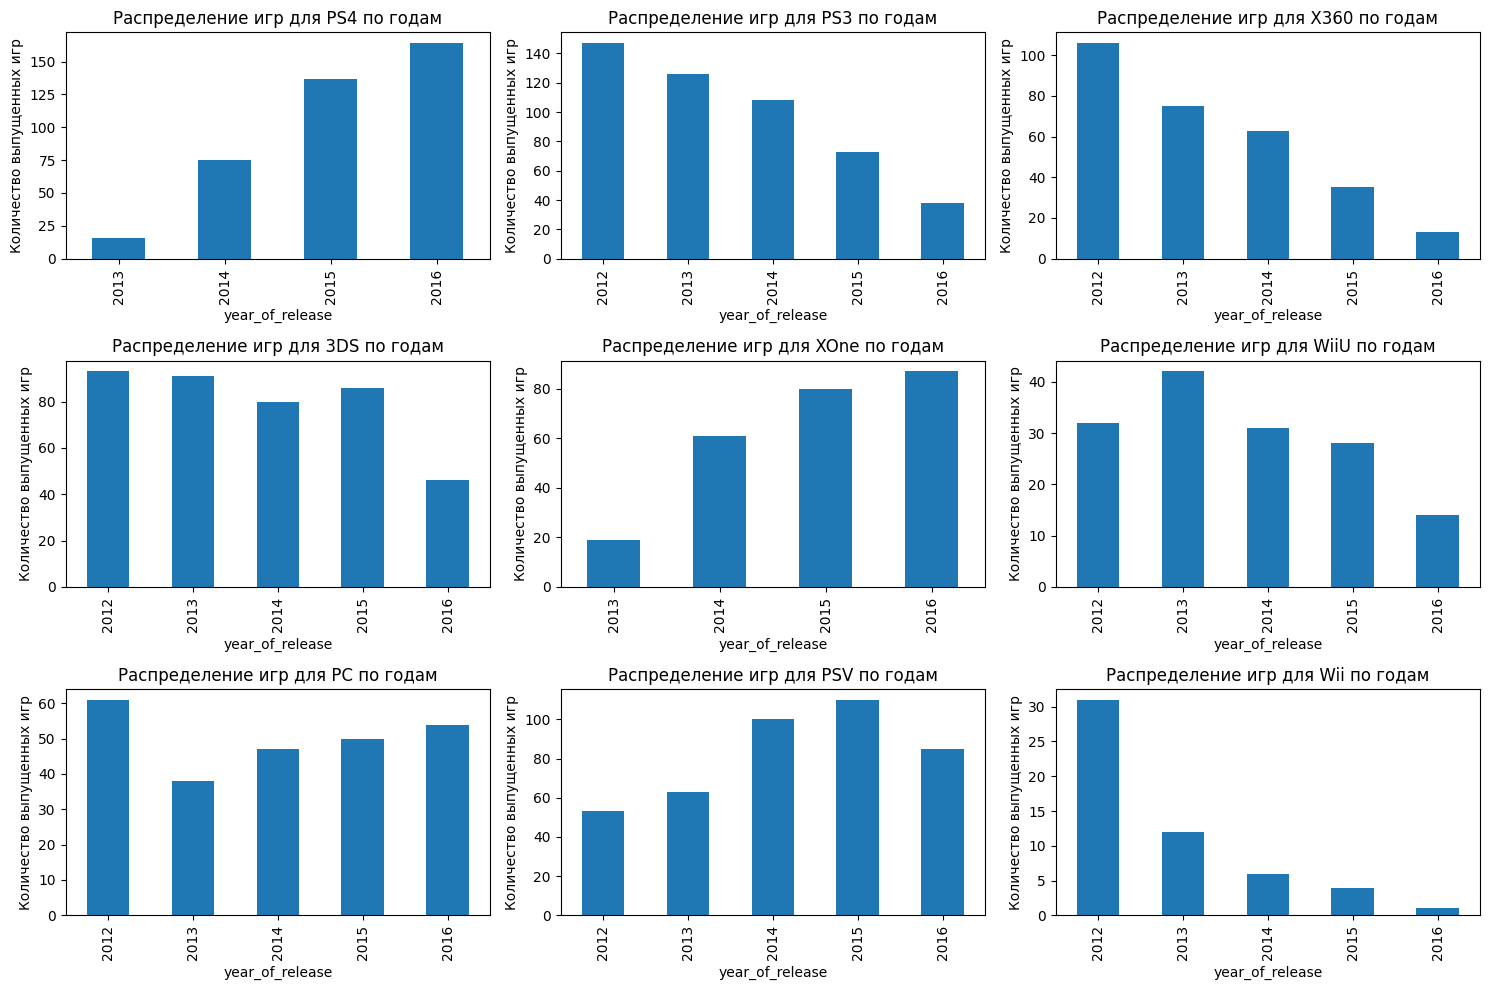

In [212]:
t_3 = df_filtered.groupby('platform').sum(numeric_only=True).sort_values(by='total_sales', ascending=False).reset_index()['platform']
t_3 = t_3.head(9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Сетка 3 х 3

for index, ax in enumerate(axes.flat):
    if index < len(t_3):
        platform = t_3[index]
        plt.sca(ax)
        plot_games_per_year_for_X(df_filtered, platform)

plt.tight_layout()
plt.show()

**Выбранные платформы с точки зрения роста или падения распределились следующим образом:**

- **`'PS4'`** - уверенный рост до 2016;
- **`'PS3'`** - линейное падение до 2016;
- **`'X360'`** - линейное падение до 2016;
- **`'3DS'`** - резкое падение в 2016;
- **`'XOne'`** - уверенный рост до 2016;
- **`'WiiU'`** - линейное падение до 2016 с пиком в 2013;
- **`'PC'`** - падение в 2013 и далее рост до 2016;
- **`'PSV'`** - падение в 2016;
- **`'Wii'`** - сильное падение до 2016.

**Платформы, имеющие рост на момент 2016 года: `'PS4'`, `'XOne'`, `'PC'`. На них далее и сосредоточимся.**

**Для выбранных платформ построим диаграмму размаха по суммарным продажам.**

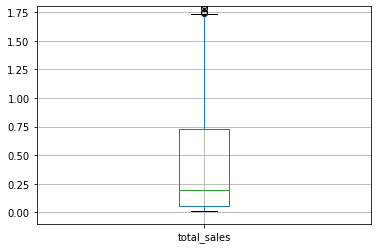

In [ ]:
plt.ylim(-0.1, 1.8)
df_filtered_ps4 = df_filtered[df_filtered['platform'] == 'PS4'].copy()
df_filtered_ps4.boxplot(column='total_sales');

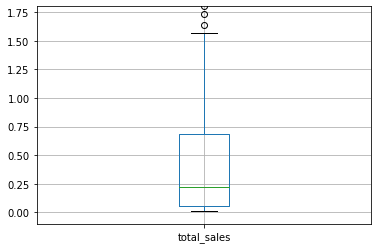

In [ ]:
plt.ylim(-0.1, 1.8)
df_filtered_xone = df_filtered[df_filtered['platform'] == 'XOne'].copy()
df_filtered_xone.boxplot(column='total_sales');

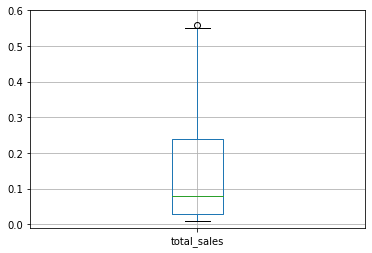

In [ ]:
plt.ylim(-0.01, 0.6)
df_filtered_pc = df_filtered[df_filtered['platform'] == 'PC'].copy()
df_filtered_pc.boxplot(column='total_sales');

**Т.к. в диаграммах размаха для всех трех платформ мы видим, что медиана тяготеет больше к нижнему краю ящика, а верхняя граница от нее находится сильно дальше, можно сделать вывод, что количество выбросов в каждом случае невелико. Среднее значение продаж игр для `'PS4'`, `'XOne'` составляет около 250 тыс. экземпляров, для `'PC'` - около 100 тыс. экземпляров.**

**Рассмотрим, для каких именно игр характерны выбросы в диаграмме размаха по каждой из платформ.**

In [ ]:
def usy_boxplota(df, column): #функция, определяющая значения усов диаграммы размаха
    min = df[column].min()
    max = df[column].max()
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR  = Q3 - Q1
    lowest = (lambda: min if min > Q1 - 1.5 * IQR else Q1 - 1.5 * IQR)
    highest = (lambda: max if max < Q3 + 1.5 * IQR else Q3 + 1.5 * IQR)
    return [lowest(), highest()]

def games_above_boxplot(df): #функция, формирующая датафрейм из значений-выбросов
    return (df[df['total_sales'] > usy_boxplota(df, 'total_sales')[1]]
            .sort_values(by='total_sales', ascending=False)
            .reset_index(drop=True))

top_ps4_games = games_above_boxplot(df_filtered_ps4)
top_ps4_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total_sales_range
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Empty,14.63,"(12.381, 16.508]"
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,"(12.381, 16.508]"
2,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,"(8.254, 12.381]"
3,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1.0,-1.0,Empty,7.98,"(4.127, 8.254]"
4,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66,"(4.127, 8.254]"
5,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60,"(4.127, 8.254]"
6,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17,"(4.127, 8.254]"
7,FIFA 15,PS4,2014,Sports,0.80,4.33,0.05,0.90,82.0,5.7,E,6.08,"(4.127, 8.254]"
8,Destiny,PS4,2014,Shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64,"(4.127, 8.254]"
9,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39,"(4.127, 8.254]"


In [ ]:
top_xone_games = games_above_boxplot(df_filtered_xone)
top_xone_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total_sales_range
0,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,-1.0,-1.0,Empty,7.39,"(4.127, 8.254]"
1,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47,"(4.127, 8.254]"
2,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26,"(4.127, 8.254]"
3,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49,"(4.127, 8.254]"
4,Fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88.0,6.2,M,4.22,"(4.127, 8.254]"
5,Star Wars Battlefront (2015),XOne,2015,Shooter,2.04,1.28,0.02,0.32,-1.0,-1.0,Empty,3.66,"(-0.0825, 4.127]"
6,Assassin's Creed: Unity,XOne,2014,Action,2.27,0.90,0.00,0.33,72.0,4.1,M,3.50,"(-0.0825, 4.127]"
7,Destiny,XOne,2014,Shooter,2.14,0.92,0.00,0.31,75.0,5.5,T,3.37,"(-0.0825, 4.127]"
8,Gears of War: Ultimate Edition,XOne,2015,Shooter,2.61,0.33,0.00,0.34,82.0,7.5,M,3.28,"(-0.0825, 4.127]"
9,FIFA 16,XOne,2015,Sports,0.89,2.12,0.00,0.24,84.0,4.4,E,3.25,"(-0.0825, 4.127]"


In [ ]:
top_pc_games = games_above_boxplot(df_filtered_pc)
top_pc_games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total_sales_range
0,Diablo III,PC,2012,Role-Playing,2.44,2.16,0.0,0.54,88.0,4.0,M,5.14,"(4.127, 8.254]"
1,The Sims 4,PC,2014,Simulation,1.00,1.82,0.0,0.23,70.0,3.9,T,3.05,"(-0.0825, 4.127]"
2,Guild Wars 2,PC,2012,Action,0.96,1.07,0.0,0.27,90.0,7.9,T,2.30,"(-0.0825, 4.127]"
3,World of Warcraft: Mists of Pandaria,PC,2012,Role-Playing,0.84,0.76,0.0,0.22,82.0,4.8,T,1.82,"(-0.0825, 4.127]"
4,StarCraft II: Heart of the Swarm,PC,2013,Strategy,0.83,0.66,0.0,0.18,86.0,7.9,T,1.67,"(-0.0825, 4.127]"
5,Call of Duty: Black Ops II,PC,2012,Shooter,0.64,0.69,0.0,0.19,74.0,4.2,M,1.52,"(-0.0825, 4.127]"
6,SimCity (2013),PC,2013,Simulation,0.48,0.77,0.0,0.17,64.0,2.2,E10+,1.42,"(-0.0825, 4.127]"
7,Battlefield 4,PC,2013,Shooter,0.39,0.87,0.0,0.10,81.0,6.0,M,1.36,"(-0.0825, 4.127]"
8,Fallout 4,PC,2015,Role-Playing,0.51,0.67,0.0,0.10,84.0,5.4,M,1.28,"(-0.0825, 4.127]"
9,Farming Simulator 2015,PC,2014,Simulation,0.08,1.04,0.0,0.07,-1.0,-1.0,Empty,1.19,"(-0.0825, 4.127]"


**Во всех трех датафреймах мелькают похожие названия игр, попавших в выбросы для каждой из трех платформ. Посмотрим фактическую долю вхождения выбросов одной платформы в другие.**

In [ ]:
def share_1_in_2(x,name_x,y, name_y): # функция, определяющая долю вхождения значений первого датафрейма  во второй
    return (len(y.merge(
        x,
        how = 'inner' ,
        left_on = name_y,
        right_on = name_x))
    / len(x))

share_1_in_2(top_xone_games, 'name', top_ps4_games, 'name')

0.7777777777777778

**Почти 78% топовых с точки зрения продаж игр для Xbox One входят в список топовых по продажам для PS4.**l

In [ ]:
share_1_in_2(top_pc_games, 'name', top_ps4_games, 'name')

0.3225806451612903

**Почти 32% топовых с точки зрения продаж игр для PC входят в список топовых по продажам для PS4.**

In [ ]:
share_1_in_2(top_pc_games, 'name', top_xone_games, 'name')

0.22580645161290322

**Почти 22% топовых с точки зрения продаж игр для PC входят в список топовых по продажам для Xbox One.**

**Посмотрим, как влияют на продажи внутри PS4 отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.**

In [ ]:
df_filtered_ps4[df_filtered_ps4['critic_score'] >= 0][['critic_score','total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.406568
total_sales,0.406568,1.000000


**Корреляция между отзывами критиков и продажами есть, она положительная, но не сильно линейная.**

In [ ]:
df_filtered_ps4[df_filtered_ps4['user_score'] >= 0][['user_score','total_sales']].corr()

,user_score,total_sales
user_score,1.000000,-0.031957
total_sales,-0.031957,1.000000


**Корреляция между отзывами пользователей и продажами практически отсутствует.**

**Построим теперь диаграммы рассеяния.**

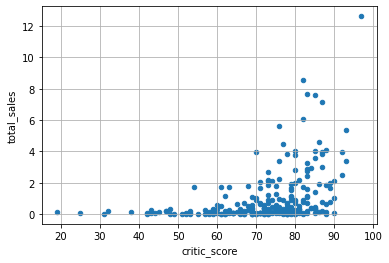

In [ ]:
(df_filtered_ps4[df_filtered_ps4['critic_score'] >= 0]
 .plot(
     x='critic_score',
     y='total_sales',
     kind='scatter',
     alpha=1, grid=True));

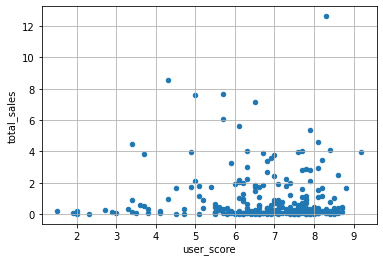

In [ ]:
(df_filtered_ps4[df_filtered_ps4['user_score'] >= 0]
 .plot(
     x='user_score',
     y='total_sales',
     kind='scatter',
     alpha=1, grid=True));

**Построенные диаграммы подтверждают выводы, сделанные по корреляции.**

**Посмотрим теперь на аналогичные корреляции для платформы Xbox One.**

In [ ]:
df_filtered_xone[df_filtered_xone['critic_score'] >= 0][['critic_score','total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.416998
total_sales,0.416998,1.000000


In [ ]:
df_filtered_xone[df_filtered_xone['user_score'] >= 0][['critic_score','total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.333579
total_sales,0.333579,1.000000


**Видим, что в случае платформы Xbox One в отличие от PS4 есть небольшая, но положительная корреляция между отзывами пользователей и продажами игры. Что касается корреляции отзывов критиков и продаж - она аналогичная платформе PS4.**

**Посмотрим теперь аналогичные зависимости для платформы PC.**

In [ ]:
df_filtered_pc[df_filtered_pc['critic_score'] >= 0][['critic_score','total_sales']].corr()

,critic_score,total_sales
critic_score,1.000000,0.237243
total_sales,0.237243,1.000000


In [ ]:
df_filtered_pc[df_filtered_pc['user_score'] >= 0][['user_score','total_sales']].corr()

,user_score,total_sales
user_score,1.000000,-0.121867
total_sales,-0.121867,1.000000


**В случае платформы PC ситуация повторяется аналогичная PS4, но в данном случае отзывы критиков еще меньше положительно коррелируют в продажами игр.**

**Посмотрим теперь на общее распределение игр по жанрам. Оценим связь продаж с жанрами.
Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

In [ ]:
df_filtered.groupby('genre').sum().sort_values(by='total_sales', ascending=False)['total_sales']

genre
Action          441.12
Shooter         304.73
Role-Playing    192.80
Sports          181.06
Misc             85.04
Platform         61.00
Racing           53.50
Fighting         44.49
Simulation       35.12
Adventure        29.43
Strategy         13.34
Puzzle            4.89
Name: total_sales, dtype: float64

**Это распределение по жанрам с точки зрения суммарных продаж.**

**Посмотрим теперь, как соотносится медиана продаж по жанрам.**

In [ ]:
df_filtered.groupby('genre').median().sort_values(by='total_sales', ascending=False)['total_sales']

genre
Shooter         0.440
Sports          0.240
Platform        0.210
Role-Playing    0.140
Racing          0.140
Fighting        0.130
Action          0.120
Misc            0.120
Simulation      0.120
Strategy        0.080
Puzzle          0.045
Adventure       0.030
Name: total_sales, dtype: float64

**Отсюда можно сделать следующие выводы:**

**Самые прибыльные жанры: `'Action'`, `'Shooter'`, `'Sports'`.**

**Самые неприбыльные жанры: `'Puzzle'`, `'Adventure'`.**

### Выводы раздела.

**В настоящий момент наблюдается спад с 2012 года в выпуске кол-ва новых игр.**

**Средний жизненный цикл одной платформы составляет 9 лет.**

**При этом обычно эти 9 лет жизни выглядят так: 5 лет линейного роста выпуска игр под платформу, после чего идет линейный спад выпуска кол-ва игр под платформу.**

**Для планирования закупки потенциально прибыльных игр на 2017 год есть смысл рассматривать данные начиная с 2012 года.**

**Наиболее потенциально прибыльные платформы: `'PS4'`, `'XOne'`, `'PC'`.**

**Отзывы пользователей почти не коррелируют с продажами, а вот отзывы критиков имеют небольшую положительную корреляцию.**

**Самые прибыльные жанры: `'Action'`, `'Shooter'`, `'Sports'`.**

**Самые неприбыльные жанры: `'Puzzle'`, `'Adventure'`.**

###  Анализ портретов пользователя каждого региона.

**Определим для пользователя каждого региона (NA, EU, JP) следующее:**
- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

**Начнем с определения самых популярных платформ (топ-5) для каждого региона. Предварительно создадим дополнительные столбцы в отфильтрованном датафрейме, которые будут указывать долю продаж данной игры от общего числа проданных экземпляров для каждого региона.**

In [ ]:
df_filtered['share_na_sales'] = df_filtered['na_sales'] / df_filtered['na_sales'].sum()
df_filtered['share_eu_sales'] = df_filtered['eu_sales'] / df_filtered['eu_sales'].sum()
df_filtered['share_jp_sales'] = df_filtered['jp_sales'] / df_filtered['jp_sales'].sum()
df_filtered.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total_sales_range,share_na_sales,share_eu_sales,share_jp_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,"(20.635, 24.762]",0.011879,0.017936,0.005089
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,"(12.381, 16.508]",0.016346,0.010142,0.000312
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Empty,14.63,"(12.381, 16.508]",0.010204,0.011563,0.001869
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,Empty,14.60,"(12.381, 16.508]",0.008934,0.008267,0.022588
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79,"(12.381, 16.508]",0.008444,0.011306,0.003375


**Теперь сформируем для каждого региона свой рейтинг топ-5 платформ по количеству продаж и выведем значение в долях.**

In [ ]:
df_filtered.groupby('platform').sum().sort_values(by='share_na_sales', ascending=False)['share_na_sales'].head()

platform
X360    0.236983
PS4     0.184003
PS3     0.174933
XOne    0.157571
3DS     0.093592
Name: share_na_sales, dtype: float64

In [ ]:
df_filtered.groupby('platform').sum().sort_values(by='share_eu_sales', ascending=False)['share_eu_sales'].head()

platform
PS4     0.278388
PS3     0.210829
X360    0.147037
XOne    0.101794
3DS     0.084134
Name: share_eu_sales, dtype: float64

In [ ]:
df_filtered.groupby('platform').sum().sort_values(by='share_jp_sales', ascending=False)['share_jp_sales'].head()

platform
3DS     0.455862
PS3     0.183249
PSV     0.109253
PS4     0.082875
WiiU    0.067556
Name: share_jp_sales, dtype: float64

**Видим, что картина по регионам отличается. Если в Северной Америке топ-1 занимет американская платформа от компании Microsoft - Xbox 360, то в Европе лидирует платформа PS4 от Sony, при этом в Японии лидирует Nintendo 3DS. Специфика пользователей данных регионов такова, что в каждом из них больше предпочитают свою платформу. Однако, в Европе и Северной Америке остальная часть рейтинга платформ почти идентична, хотя Япония как рынок очень специфична и это видно по тому, как сильно отличается топ-5 платформ пользователей из Японии, от пользователей из Европы и Северной Америки.**

**Посмотрим теперь аналогичный расклад по топ-5 жанров игр в данных 3 регионах продаж.**

In [ ]:
df_filtered.groupby('genre').sum().sort_values(by='share_na_sales', ascending=False)['share_na_sales'].head()

genre
Action          0.300929
Shooter         0.244970
Sports          0.137960
Role-Playing    0.108297
Misc            0.064623
Name: share_na_sales, dtype: float64

In [ ]:
df_filtered.groupby('genre').sum().sort_values(by='share_eu_sales', ascending=False)['share_eu_sales'].head()

genre
Action          0.314398
Shooter         0.223891
Sports          0.136304
Role-Playing    0.095756
Racing          0.053847
Name: share_eu_sales, dtype: float64

In [ ]:
df_filtered.groupby('genre').sum().sort_values(by='share_jp_sales', ascending=False)['share_jp_sales'].head()

genre
Role-Playing    0.339807
Action          0.274172
Misc            0.066777
Simulation      0.054055
Fighting        0.049019
Name: share_jp_sales, dtype: float64

**И опять видим, как сильно отличаются предпочтения по жанрам пользователей из Японии, где на первом месте стоит жанр Role-Playing, который в Европе и Северной Америке находится лишь на 4 месте. Рейтинг топ-4 жанров пользователей Европы и Северной Америки полностью идентичен. Это объясняется спецификой рынка Японии, который известен своей нестандартностью для пользователей из Европы и Северной Америки.**

**Определим, наконец, влияет ли рейтинг ESRB на продажи в каждом регионе отдельно.**

In [ ]:
(df_filtered
 .groupby('rating').sum()
 .sort_values(by='share_na_sales', ascending=False)['share_na_sales'])

rating
M        0.391847
E        0.193529
Empty    0.174814
E10+     0.128094
T        0.111715
Name: share_na_sales, dtype: float64

In [ ]:
(df_filtered
 .groupby('rating').sum()
 .sort_values(by='share_eu_sales', ascending=False)['share_eu_sales'])

rating
M        0.382708
E        0.223003
Empty    0.180541
E10+     0.109252
T        0.104497
Name: share_eu_sales, dtype: float64

In [ ]:
(df_filtered
 .groupby('rating').sum()
 .sort_values(by='share_jp_sales', ascending=False)['share_jp_sales'])

rating
Empty    0.565168
E        0.147108
T        0.135113
M        0.110084
E10+     0.042528
Name: share_jp_sales, dtype: float64

**Видим, что больше всего игр с рейтингом 17+ продается в Северной Америке и Европе (38-39% игр), на втором месте идут игры с рейтингом "для всех" (19-22%), а 3е место (17-18%) занимают данные, по которым отсутствует информация о рейтинге, что может повлиять на итоговое распределение предпочтений. В Японии же лидирует по доле данные, по которым рейтинг неизвестен, соответственно, можно очень условно делать предположение о предпочтениях Японских пользователей в жанрах игр на основе имеющихся у нас данных. В идеале попробовать получить корректные данные по рейтингу от коллег, кто готовил датасет и заново проанализировать.**

### Выводы раздела.

**Портрет пользователей из Японии сильно отличается от портрета пользователей из Европы и Северной Америки, как в части выбора жанров игр, так и в части предпочтения игровых платформ и большей популярности игр с иным рейтингом ESRB.**

**В Северной Америке топ-1 занимет американская платформа от компании Microsoft - Xbox 360, в Европе лидирует платформа PS4 от Sony, при этом в Японии лидирует Nintendo 3DS. В Европе и Северной Америке остальная часть рейтинга платформ почти идентична, а в Японии - нет.**

**На первом месте по продажам в Японии стоит жанр Role-Playing, который в Европе и Северной Америке находится лишь на 4 месте. Рейтинг топ-4 жанров пользователей Европы и Северной Америки полностью идентичен, в Японии же рейтинг жанров совсем иной.**

**Больше всего игр с рейтингом 17+ продается в Северной Америке и Европе (38-39% игр), на втором месте идут игры с рейтингом "для всех" (19-22%), а 3е место (17-18%) занимают данные, по которым отсутствует информация о рейтинге, что может повлиять на итоговое распределение предпочтений. В Японии же лидирует по доле данные, по которым рейтинг неизвестен, соответственно, можно очень условно делать предположение о предпочтениях Японских пользователей в жанрах игр на основе имеющихся у нас данных. В идеале попробовать получить корректные данные по рейтингу от коллег, кто готовил датасет и заново проанализировать.**

## Проверка гипотез.

### Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Нулевая гипотеза звучит так: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

**Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC отличаются.**

alpha = 0.05

In [ ]:
#вызов метода для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
result = st.ttest_ind(
    df_filtered[(df_filtered['platform'] =='XOne') & (df_filtered['user_score'] > 0)]['user_score'],
    df_filtered[(df_filtered['platform'] =='PC') & (df_filtered['user_score'] > 0)]['user_score'],
    equal_var=False)
# equal_var=False, т.к. выборки разного размера и есть сомнения, что дисперсии у совокупностей одинаковые

alpha = 0.05 # задаем уровень значимости

print(result.pvalue) # вывод значения p-value на экран
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Cредняя оценка для Xbox One:', df_filtered[
    (df_filtered['platform'] =='XOne') &
    (df_filtered['user_score'] > 0)]
      ['user_score'].mean().round(1))
print('Cредняя оценка для PC:', df_filtered[
    (df_filtered['platform'] =='PC') &
    (df_filtered['user_score'] > 0)]
      ['user_score'].mean().round(1))

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу
Cредняя оценка для Xbox One: 6.5
Cредняя оценка для PC: 6.4


**По результатам теста вывод такой, что у нас с выбранным уровнем значимости не получилось отвергнуть нулевую гипотезу. Считаем, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

### Гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

**Нулевая гипотеза звучит так: средние пользовательские рейтинги жанров Action и Sports одинаковые.**

**Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports отличаются.**

alpha = 0.05

In [ ]:
#вызов метода для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
result = st.ttest_ind(
    df_filtered[(df_filtered['genre'] =='Action') & (df_filtered['user_score'] > 0)]['user_score'],
    df_filtered[(df_filtered['genre'] =='Sports') & (df_filtered['user_score'] > 0)]['user_score'],
    equal_var=False)
# equal_var=False, т.к. выборки разного размера и есть сомнения, что дисперсии у совокупностей одинаковые

alpha = 0.05 # задаем уровень значимости

print(result.pvalue) # вывод значения p-value на экран
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Cредняя оценка для Action:', df_filtered[
    (df_filtered['genre'] =='Action') &
    (df_filtered['user_score'] > 0)]
      ['user_score'].mean().round(1))
print('Cредняя оценка для Sports:', df_filtered[
    (df_filtered['genre'] =='Sports') &
    (df_filtered['user_score'] > 0)]
      ['user_score'].mean().round(1))

5.989458066467418e-20
Отвергаем нулевую гипотезу
Cредняя оценка для Action: 6.8
Cредняя оценка для Sports: 5.5


**По результатам теста вывод такой, что с выбранным уровнем значимости мы отвергаем нулевую гипотезу. Считаем, что средние пользовательские рейтинги жанров Action и Sports отличаются.**

## Общий вывод.

**Первоначальная задача стояла выявить определяющие успешность с точки зрения продаж игры закономерности. Необходимо спланировать кампанию на 2017-й.**

**Для успешного планирования необходимо выяснить, для какого именно рынка (NA, EU, JP) предполагается кампания на 2017й год.**

**Также мы анализировали данные в количествах проданных экземпляров, в бизнесе нужна аналитика с точки зрения получения максимальной прибыли, т.е. нам необходимы были бы дополнительные данные по стоимости закупки и продажи игр для нашей компании по каждой из платформ.**

**---------------------------------------------------------------------------------------------------------------------------**

**Если же мы работаем глобально, то выводы следующие:**

**В настоящий момент наблюдается спад с 2012 года в выпуске кол-ва новых игр.**

**Средний жизненный цикл одной игровой платформы составляет 9 лет.**

**При этом обычно эти 9 лет жизни выглядят так: 5 лет линейного роста выпуска игр под платформу, после чего идет линейный спад выпуска кол-ва игр под платформу.**

**Наиболее потенциально прибыльные платформы: `'PS4'`, `'XOne'`, `'PC'`.**

**Отзывы пользователей почти не коррелируют с продажами, а вот отзывы критиков имеют небольшую положительную корреляцию.**

**Самые прибыльные жанры: `'Action'`, `'Shooter'`, `'Sports'`.**

**Самые неприбыльные жанры: `'Puzzle'`, `'Adventure'`.**